In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from qnetwork.tools import set_plot_style
from experiment_0 import exp000
from experiment_1 import exp001
from experiment_5 import exp005

from qnetwork.tools import set_plot_style
plt.rcParams['mathtext.fontset'] = 'cm'

In [2]:
set_plot_style()

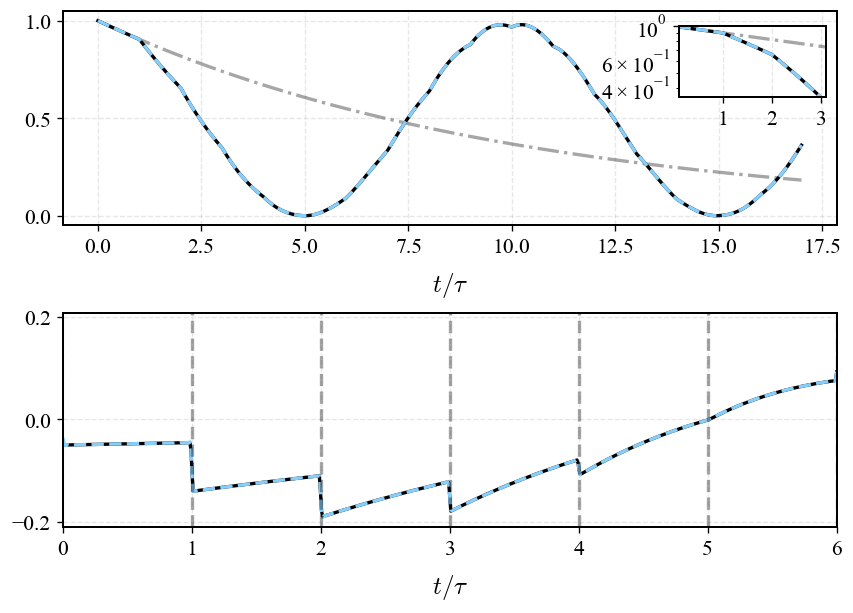

In [3]:
exp000(Delta=50,gamma=0.05,periods_derivative=6,n_steps=2001,n_modes=100)

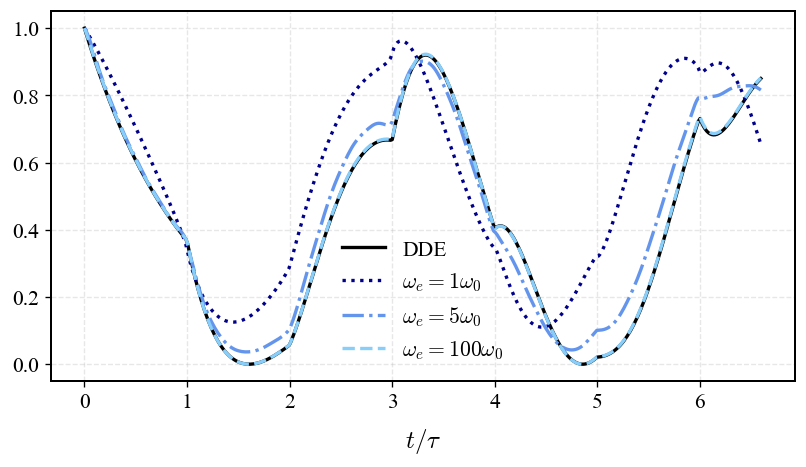

In [4]:
exp001(gamma=0.5,Delta_list=[1,5,100],n_points=201)

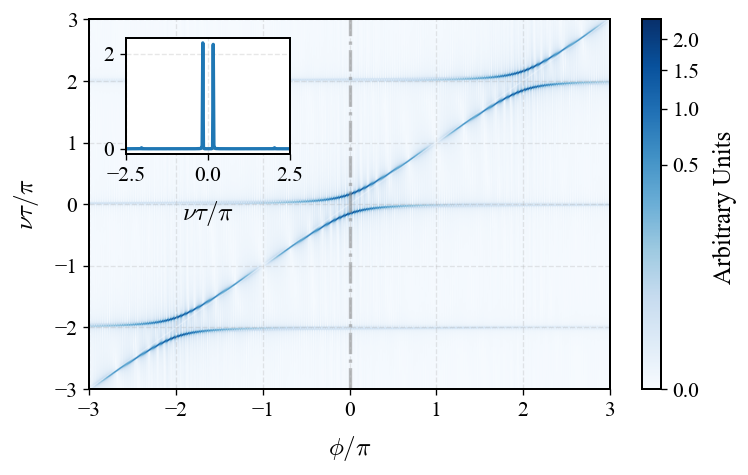

In [5]:
exp005(gamma=0.25,phi_range =list(np.linspace(-3*np.pi,3*np.pi,600)))

In [ ]:
from experiment_2 import parameter_correction
from scipy.integrate import trapezoid
from aux_funs import paralelizar,DDE_analytical,run_ww_simulation
from scipy.optimize import minimize 
from functools import partial 


def L2_error(x,y1,y2):
	dif = y1-y2
	return trapezoid(y=np.sqrt(dif**2),x=x) / trapezoid(y=np.sqrt(y2**2),x=x)

def param_correction(   gamma:float=0.1,
						Delta:float =1,
						L:float =1,
						c:float = 1, 
						n_modes:int = 50,
						n_steps:int = 501,
						method_m: str = 'Powell'):
	''' given Delta and gamma, returns the renormalized set of parameters that best 
	recover Rabi-like behavior. The criterion is that, in the first period, the minumun value goes closest to 0. '''

	tau=2*L/c
	T = np.pi/(np.sqrt(gamma/tau))
	t_max = 3*T
	t=np.linspace(0,t_max,n_steps)

	e_dde = np.abs(DDE_analytical(gamma=gamma,phi=0,tau=tau,t=t))**2

	def error_estimation(args):
		Delta,gamma=args
		Delta = float(Delta)
		gamma = float(gamma)
		_,e_ww = run_ww_simulation(t_max=t_max,gamma = gamma,Delta=Delta,L=L,c=c,n_modes=n_modes,n_steps=n_steps)  
		return L2_error(x=t,y1=e_ww,y2=e_dde)
	
	res = minimize(error_estimation,
				x0=[Delta,gamma],
				bounds=[(Delta-0.3,Delta+0.3),(0,gamma+0.1)],
				method=method_m)

	lamb_shift = res.x[0]-Delta
	gamma_correction = res.x[1] - gamma 
	return [lamb_shift,gamma_correction]


def exp007(gamma_list : list = list(np.linspace(0.05,0.2,12)),
			 Delta_list: list= [1,2,3],
			 L:float = 1,
			 c:float =1,
			 n_modes: int = 60,
			 n_steps: int = 601,
			 method_m:str='Powell',
			 ):
	
	''' This experiment is ment to analyze the differences between a renormalized cavity and the 
	dde solution'''
	tau = 2*L/c
	t_max = 5*tau
	t = np.linspace(0,t_max,n_steps)
	fig,axs = plt.subplots(figsize=(8,4))
	axs.set_xlabel(r"$\gamma / FSR$")
	data=[]

	def sample_gamma(gamma,Delta):
		e_ref = np.abs(DDE_analytical(gamma=gamma,phi=0,tau=2*L/c,t=t))**2	
		dls,gls = param_correction(gamma=gamma,Delta=Delta,L=L,c=c,n_modes=n_modes,n_steps=n_steps,method_m=method_m)
		Delta_r = Delta+dls
		gamma_r =gamma+gls
		_,e_ren = run_ww_simulation(t_max=t_max,gamma=gamma_r,Delta=Delta_r,L=L,c=c,n_steps=n_steps,n_modes=n_modes)
		error_est = L2_error(x=t,y1=e_ren,y2=e_ref)
		return error_est

	for Delta in Delta_list:
		fun = partial(sample_gamma,Delta=Delta)
		error = paralelizar(parameter_list=gamma_list,f=fun)
		data.append(error)
		axs.plot(np.asarray(gamma_list)/np.pi,error,'-o',label=rf"$\omega_e ={Delta:.0f} \omega_0 $")
	axs.legend()
	plt.show()

	return data 
	
	


In [51]:
gamma=0.2
Delta=1
L=1
c=1
n_modes = 50
n_steps=501
method_m = 'Powell'
t_max = 20

t=np.linspace(0,t_max,n_steps)
e_dde= np.abs(DDE_analytical(gamma=gamma,phi=0,tau=2*L/c,t=t))**2

dls,gls = param_correction(gamma=gamma,Delta=Delta,L=L,c=c,n_modes=n_modes,n_steps=n_steps,method_m=method_m)



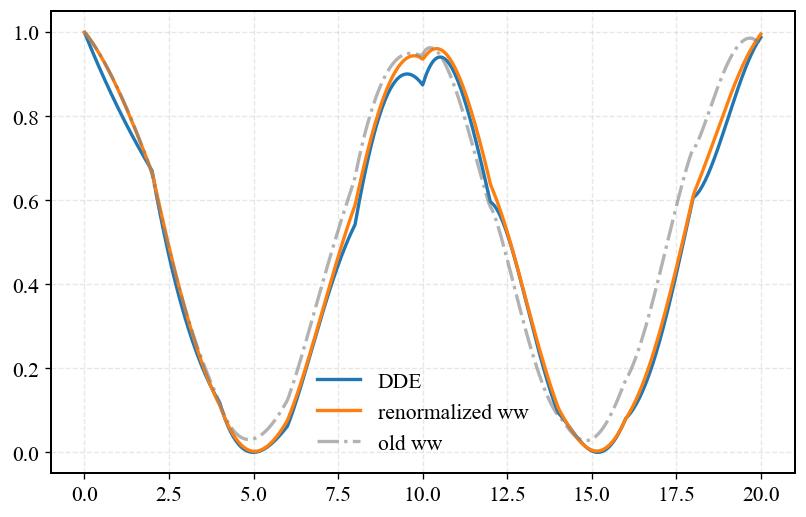

In [52]:
_,e_ww= run_ww_simulation(t_max=t_max,gamma=gamma+gls,Delta=Delta+dls,L=L,c=c,n_steps=n_steps)
_,e_old = run_ww_simulation(t_max=t_max,gamma=gamma,Delta=Delta,L=L,c=c,n_steps=n_steps)

plt.plot(t,e_dde,label='DDE')
plt.plot(t,e_ww,label='renormalized ww')
plt.plot(t,e_old,linestyle='dashdot',color='gray',alpha=0.6,label='old ww')
plt.legend()
plt.show()